In [16]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D, Dropout, Input
from keras.layers.convolutional import Conv1D, Conv2D
from keras.optimizers import SGD, Adam
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Load the audio data

In [3]:
multitracks = mdb.load_multitracks([
    "Phoenix_ColliersDaughter", 
    "Phoenix_BrokenPledgeChicagoReel", 
    "Phoenix_ElzicsFarewell", 
    "Phoenix_LarkOnTheStrandDrummondCastle",
    "Phoenix_ScotchMorris",
    "Phoenix_SeanCaughlinsTheScartaglen"
])

In [4]:
mix_audio = None
instrument_audio = None

for mix in multitracks:
    sample_rate, song = wavfile.read(mix.mix_path)
    
    if mix_audio is None:
        mix_audio = song
    
    else:
        mix_audio = np.concatenate((mix_audio, song))
    
    #
    
    instruments = mdb.get_files_for_instrument("violin", [mix])

    instrument = next(instruments)
    
    sample_rate, track = wavfile.read(instrument)
    
    if instrument_audio is None:
        instrument_audio = track
    
    else:
        instrument_audio = np.concatenate((instrument_audio, track))
    
mix_audio = mix_audio.mean(1)
instrument_audio = instrument_audio.mean(1)

In [5]:
samples_per_period = 256
overlap = int(samples_per_period/2)

# Process the Mix

In [6]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [7]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
#plt.title("STFT of the Mix")
#plt.ylabel("Frequency (Hz)")
#plt.xlabel("Time (s)")

# Process the Target Instrument

In [8]:
freqs, times, s_instrument = signal.stft(instrument_audio, fs=sample_rate, nfft=samples_per_period, 
                                               noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_instrument = s_instrument[:-1,:]
s_instrument += 1e-9

In [9]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_instrument)))
#plt.title("STFT of the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [10]:
num_test  = int((sample_rate * 120)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

374742 20671


In [11]:
mix_train = s_mix.T[:num_train,np.newaxis,:]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=1)
mix_train.shape

(374742, 2, 128)

In [12]:
instrument_train = s_instrument.T[:num_train,np.newaxis,:]
instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=1)
instrument_train.shape

(374742, 2, 128)

In [13]:
mix_test = s_mix.T[-num_test:,np.newaxis,:]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=1)
mix_test.shape

(20671, 2, 128)

In [14]:
instrument_test = s_instrument.T[-num_test:,np.newaxis,:]
instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=1)
instrument_test.shape

(20671, 2, 128)

In [18]:
model = Sequential()

model.add(Conv1D(128, 2, input_shape=mix_train.shape[1:], padding="same", activation="relu"))
model.add(Conv1D(64, 2, padding="same",  activation="relu"))

model.add(Dense(64))

model.add(Conv1D(64, 2, padding="same",  activation="relu"))
model.add(Conv1D(128, 2, padding="same",  activation="relu"))

model.add(Dense(128))

model.summary()

ValueError: Negative dimension size caused by subtracting 3 from 2 for 'conv1d_6/convolution/Conv2D' (op: 'Conv2D') with input shapes: [?,1,2,128], [1,3,128,128].

In [63]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#sgd = SGD(lr=0.001, momentum=1.1, decay=1.1, nesterov=True)

model.compile(adam, loss='mean_squared_error', metrics=['accuracy'])

In [64]:
history = model.fit(mix_train, instrument_train, batch_size=1000, epochs=5)

Epoch 1/5
374742/374742 [==============================] - 5s 13us/step - loss: 2227.1857 - acc: 0.2851
Epoch 2/5
374742/374742 [==============================] - 4s 11us/step - loss: 1750.8044 - acc: 0.3986
Epoch 3/5
374742/374742 [==============================] - 4s 10us/step - loss: 1651.5582 - acc: 0.4084
Epoch 4/5
374742/374742 [==============================] - 4s 11us/step - loss: 1605.4908 - acc: 0.4111
Epoch 5/5
374742/374742 [==============================] - 4s 10us/step - loss: 1575.1957 - acc: 0.4127


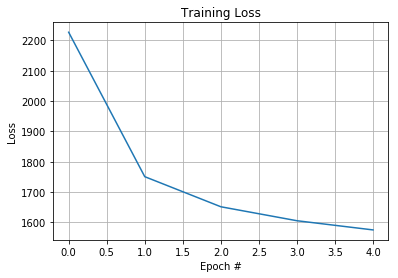

In [65]:
plt.plot(history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.grid()

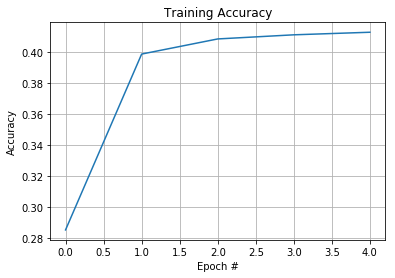

In [66]:
plt.plot(history.history['acc'])
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.grid()

In [67]:
results = model.evaluate(mix_test, instrument_test)

print(model.metrics_names)
print(results)

20671/20671 [==============================] - 1s 53us/step
['loss', 'acc']
[1700.2427080441605, 0.42511247640686395]


# Results

In [68]:
prediction = model.predict(mix_test)
prediction.shape

(20671, 2, 128)

In [69]:
prediction = (prediction[:,0,:]+prediction[:,1,:] * 1j).T
prediction += 1e-9

In [70]:
target = s_instrument[:, -num_test:]

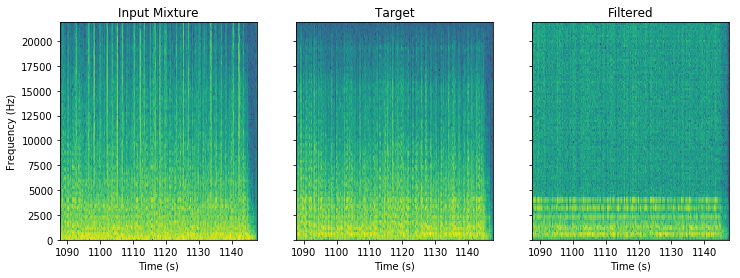

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Filtered")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [72]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)
_, target_audio = signal.istft(target, fs=sample_rate)
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

wavfile.write("fcn_model_3_instrument_prediction.wav", sample_rate, predicted_audio.astype(np.int16))
wavfile.write("fcn_model_3_instrument_target.wav", sample_rate, target_audio.astype(np.int16))
wavfile.write("fcn_model_3_original.wav", sample_rate, mix_audio.astype(np.int16))